In [ ]:
from pathlib import Path
import numpy as np
import copy
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, QMNIST
from torchvision.transforms.transforms import Resize
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import os.path
import pickle
from typing import Any, Callable, Optional, Tuple
import numpy as np
from PIL import Image
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

> **Architectures.** For experiments on CIFAR-10, CIFAR-100 and CINIC-10, we use a variant of ResNet-18 (He et al., 2016). We adapted the ResNet18 to 32x32 images by modifying the architecture to remove the downsampling effect. We replaced the spatial downsampling of a strided convolution and max pooling in the original ResNet18, with a convolutional layer with 64 filters and a kernel size of 3x3. We also removed the average pooling at the end of the ResNet18. This ResNet18 variant is similar to Resnet20, just with more filters

**Resnet Architecture as mentioned in paper:** [ https://github.com/OATML/RHO-Loss/blob/4c88851742ce5397153f4fef80abd4682958ac56/src/models/modules/resnet_cifar.py#L86 ]


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

def resnet18_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet18(pretrained=pretrained, num_classes=1000)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, classes, bias=True)
    return model

def resnet50_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet50(pretrained=pretrained, num_classes=1000)
    model.fc = nn.Linear(512, classes, bias=True)
    return model

**Modified code with MC dropout:**

Monte Carlo Dropout (MC‑Dropout) is a simple way to turn a standard neural network with dropout layers into an approximate Bayesian model that can estimate uncertainty in its predictions. Here’s how it works and how you use it:

1. The Idea
Standard dropout randomly zeroes a fraction of activations only during training to regularize the network. At test time you disable dropout (i.e. use model.eval()), so the network is deterministic.

MC‑Dropout flips that around: at inference you deliberately keep dropout turned on (i.e. keep the network in train() mode) and do many forward passes through the same input, each time with a different random dropout mask.

Each pass gives you a slightly different prediction. By aggregating (e.g. by taking the mean and the variance) over these T stochastic passes, you get:

Predictive mean → your final predicted probabilities.

Predictive variance → an estimate of your model’s epistemic uncertainty (i.e. “how unsure the model is given the data it has seen”).

This simple trick was introduced in Gal & Ghahramani (2016) as a practical Bayesian approximation.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_p=0.2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout1 = nn.Dropout(p=dropout_p)

        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, dropout_p=0.2):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout1 = nn.Dropout(p=dropout_p)

        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.dropout3 = nn.Dropout(p=dropout_p)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.dropout2(out)
        out = self.bn3(self.conv3(out))
        out = self.dropout3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_p=0.2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_p=dropout_p)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_p=dropout_p)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_p=dropout_p)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_p=dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_p):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_p))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet18(dropout_p=0.2):
    return ResNet(BasicBlock, [2, 2, 2, 2], dropout_p=dropout_p)

def ResNet34(dropout_p=0.2):
    return ResNet(BasicBlock, [3, 4, 6, 3], dropout_p=dropout_p)

def ResNet50(dropout_p=0.2):
    return ResNet(Bottleneck, [3, 4, 6, 3], dropout_p=dropout_p)

def ResNet101(dropout_p=0.2):
    return ResNet(Bottleneck, [3, 4, 23, 3], dropout_p=dropout_p)

def ResNet152(dropout_p=0.2):
    return ResNet(Bottleneck, [3, 8, 36, 3], dropout_p=dropout_p)

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# Example for ImageNet variants remains unchanged

def resnet18_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet18(pretrained=pretrained, num_classes=1000)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, classes, bias=True)
    return model

def resnet50_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet50(pretrained=pretrained, num_classes=1000)
    model.fc = nn.Linear(512, classes, bias=True)
    return model


Data loading, data splitting code from: https://github.com/OATML/RHO-Loss/blob/main/src/datamodules/datamodules.py , https://github.com/OATML/RHO-Loss/blob/main/src/datamodules/datasets/sequence_datasets.py



In [ ]:
class indices_CIFAR10(VisionDataset):
    base_folder = "cifar-10-batches-py"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = "c58f30108f718f92721af3b95e74349a"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        ["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"],
        ["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"],
        ["data_batch_4", "634d18415352ddfa80567beed471001a"],
        ["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"],
    ]

    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        sequence=None,
    ) -> None:

        super(indices_CIFAR10, self).__init__(
            root, transform=transform, target_transform=target_transform
        )

        self.train = train  # training set or test set

        self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted even though we tried to download it"
            )

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                if "labels" in entry:
                    self.targets.extend(entry["labels"])
                else:
                    self.targets.extend(entry["fine_labels"])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()
        if sequence is not None:
            self.sequence = sequence
        else:
            self.sequence = np.arange(len(self.data))

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        if not check_integrity(path, self.meta["md5"]):
            raise RuntimeError("Dataset metadata file not found or corrupted")
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[self.sequence[index]], self.targets[self.sequence[index]]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return index, img, target

    def __len__(self) -> int:
        return len(self.sequence)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in self.train_list + self.test_list:
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        download_and_extract_archive(
            self.url, self.root, filename=self.filename, md5=self.tgz_md5
        )

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

class CIFAR10DataModule:
    def __init__(self, data_dir="./data", batch_size=960, test_batch_size=100, num_workers=4):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.data_aug_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def setup(self, double_irlomo=False):
        full_dataset = indices_CIFAR10(self.data_dir, train=True, transform=self.data_aug_transform)

        indices = list(range(len(full_dataset)))
        train_indices = indices[::2]
        val_indices = indices[1::2]

        self.train_split_1 = Subset(full_dataset, train_indices)
        self.train_split_2 = Subset(full_dataset, val_indices)
        self.train_split_2_indices = val_indices  # needed for irreducible loss tracking

        self.test_dataset = indices_CIFAR10(self.data_dir, train=False, transform=self.transform)

    def get_train_loader_split1(self):
        return DataLoader(self.train_split_1, batch_size=128, shuffle=True, num_workers=self.num_workers)

    def get_train_loader_split2(self):
        return DataLoader(self.train_split_2, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def get_test_loader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_batch_size, shuffle=False, num_workers=self.num_workers)

**Training IL Model:**

> **Data augmentation:** On CIFAR-10, CIFAR-100, and CINIC-10, we train using data augmentation (random crop and horizontal flip), both for training the IL model, and in the main training runs. Remember that we only compute the irreducible losses once at the start of training.

> We can efficiently compute the IL with an “irreducible loss model" (IL model) that is smaller than the target model and has low accuracy . ResNet18 IL model trained for 37x fewer steps than each target model.

Irreducible loss models can be small and cheap. In our
default setting, both the target model and IL model have the same architecture (ResNet-18).The smaller IL model accelerates training as much or more than the larger model, even though its final accuracy is far lower than the target ResNet18 (11.5% lower on CIFAR-10, 7% on CIFAR-100, and 8.1% on CINIC-10).



In [3]:
# === CONTINUATION CODE: RHO-LOSS Training on CIFAR-10 ===

import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
import random
import warnings
warnings.filterwarnings("ignore")

# ====== Set device and seed ======
torch.manual_seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Initialize DataModule and Prepare Splits ======
dm = CIFAR10DataModule()
dm.setup()

train_loader_il = dm.get_train_loader_split1()
eval_loader_il = dm.get_train_loader_split2()
test_loader = dm.get_test_loader()
train_ids = dm.train_split_2_indices

# ====== Step 1: Train IL Model ======
il_model = ResNet18().to(device)
il_optimizer = optim.AdamW(il_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(30, desc="Training IL Model"):
    il_model.train()
    correct, total = 0, 0
    for _, x, y in train_loader_il:
        x, y = x.to(device), y.to(device)
        il_optimizer.zero_grad()
        logits = il_model(x)
        loss = criterion(logits, y)
        loss.backward()
        il_optimizer.step()
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    acc = 100.0 * correct / total
    print(f"[IL Model] Epoch {epoch+1}: Accuracy = {acc:.2f}%")
    if acc >= 60.0:
        break

Files already downloaded and verified
Files already downloaded and verified
Training IL Model:  10%|█         | 3/30 [01:06<09:58, 22.15s/it][IL Model] Epoch 3: Accuracy = 61.00%


**Compute Irreducible Loss**

In [ ]:
print("Computing irreducible loss on split_2...")
il_model.eval()
irreducible_loss = {}
with torch.no_grad():
    for idx, (_, x, y) in tqdm(zip(train_ids, eval_loader_il), total=len(train_ids), desc="Computing IL"):
        x, y = x.to(device), y.to(device)
        loss = F.cross_entropy(il_model(x), y).item()
        irreducible_loss[idx] = loss

Computing irreducible loss on split_2...


Computing IL: 100%|██████████| 25000/25000 [02:30<00:00, 165.75it/s]


**Training Target Model with RHO-LOSS**

> **Hyperparameters:** All models are trained using the AdamW optimizer with default PyTorch hyperparameters (β1=0.9, β2=0.999, and weight decay of 0.01, learning rate 0.001), a nb = 32 ( nB = 320 , meaning we select nB/nb = 10% of points.We use between 2 and 10 seeds for each experiment


In [ ]:
# ====== Step 3: Train Target Model with RHO-LOSS ======
target_model = ResNet18().to(device)
target_optimizer = optim.AdamW(target_model.parameters(), lr=1e-3)
topk = 32
reached_80 = reached_875 = False

for epoch in trange(1, 300, desc="Training Target Model"):
    target_model.train()
    random.shuffle(train_ids)
    for i in range(0, len(train_ids), 320):
        ids = train_ids[i:i+320]
        x_b, y_b, il_b = [], [], []
        for idx in ids:
            _, x, y = dm.train_split_2.dataset[idx]
            x_b.append(x)
            y_b.append(y)
            il_b.append(irreducible_loss[idx])

        if len(x_b) < topk:
            continue  # skip if batch too small

        x_tensor = torch.stack(x_b).to(device)
        y_tensor = torch.tensor(y_b).to(device)
        il_tensor = torch.tensor(il_b).to(device)

        logits = target_model(x_tensor)
        losses = F.cross_entropy(logits, y_tensor, reduction='none')
        rho = losses - il_tensor
        top_indices = torch.topk(rho, topk).indices
        selected_loss = losses[top_indices].mean()

        target_optimizer.zero_grad()
        selected_loss.backward()
        target_optimizer.step()

    # ====== Evaluate on Test Set ======
    target_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for _, x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = target_model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = 100.0 * correct / total
    print(f"[Target Model] Epoch {epoch}: Accuracy = {acc:.2f}%")
    if not reached_80 and acc >= 80.0:
        print(f"✅ Reached 80% at epoch {epoch}")
        reached_80 = True
    if not reached_875 and acc >= 87.5:
        print(f"✅ Reached 87.5% at epoch {epoch}")
        reached_875 = True
    if reached_80 and reached_875:
        break

Training Target Model:   0%|          | 1/299 [00:24<2:01:57, 24.56s/it]

[Target Model] Epoch 1: Accuracy = 27.38%


Training Target Model:   1%|          | 2/299 [00:49<2:03:06, 24.87s/it]

[Target Model] Epoch 2: Accuracy = 30.19%


Training Target Model:   1%|          | 3/299 [01:13<2:01:01, 24.53s/it]

[Target Model] Epoch 3: Accuracy = 38.01%


Training Target Model:   1%|▏         | 4/299 [01:37<1:59:54, 24.39s/it]

[Target Model] Epoch 4: Accuracy = 34.03%


Training Target Model:   2%|▏         | 5/299 [02:02<1:59:17, 24.34s/it]

[Target Model] Epoch 5: Accuracy = 42.23%


Training Target Model:   2%|▏         | 6/299 [02:26<1:58:39, 24.30s/it]

[Target Model] Epoch 6: Accuracy = 35.39%


Training Target Model:   2%|▏         | 7/299 [02:50<1:57:52, 24.22s/it]

[Target Model] Epoch 7: Accuracy = 49.84%


Training Target Model:   3%|▎         | 8/299 [03:14<1:56:58, 24.12s/it]

[Target Model] Epoch 8: Accuracy = 51.95%


Training Target Model:   3%|▎         | 9/299 [03:38<1:55:59, 24.00s/it]

[Target Model] Epoch 9: Accuracy = 52.67%


Training Target Model:   3%|▎         | 10/299 [04:01<1:55:08, 23.91s/it]

[Target Model] Epoch 10: Accuracy = 59.92%


Training Target Model:   4%|▎         | 11/299 [04:25<1:54:36, 23.88s/it]

[Target Model] Epoch 11: Accuracy = 63.54%


Training Target Model:   4%|▍         | 12/299 [04:50<1:55:17, 24.10s/it]

[Target Model] Epoch 12: Accuracy = 59.04%


Training Target Model:   4%|▍         | 13/299 [05:13<1:54:19, 23.98s/it]

[Target Model] Epoch 13: Accuracy = 65.04%


Training Target Model:   5%|▍         | 14/299 [05:37<1:53:30, 23.89s/it]

[Target Model] Epoch 14: Accuracy = 67.42%


Training Target Model:   5%|▌         | 15/299 [06:01<1:52:49, 23.84s/it]

[Target Model] Epoch 15: Accuracy = 65.18%


Training Target Model:   5%|▌         | 16/299 [06:25<1:52:11, 23.79s/it]

[Target Model] Epoch 16: Accuracy = 69.44%


Training Target Model:   6%|▌         | 17/299 [06:48<1:51:37, 23.75s/it]

[Target Model] Epoch 17: Accuracy = 70.48%


Training Target Model:   6%|▌         | 18/299 [07:12<1:51:08, 23.73s/it]

[Target Model] Epoch 18: Accuracy = 69.70%


Training Target Model:   6%|▋         | 19/299 [07:36<1:50:38, 23.71s/it]

[Target Model] Epoch 19: Accuracy = 71.65%


Training Target Model:   7%|▋         | 20/299 [07:59<1:50:09, 23.69s/it]

[Target Model] Epoch 20: Accuracy = 69.85%


Training Target Model:   7%|▋         | 21/299 [08:23<1:49:47, 23.70s/it]

[Target Model] Epoch 21: Accuracy = 73.87%


Training Target Model:   7%|▋         | 22/299 [08:47<1:49:25, 23.70s/it]

[Target Model] Epoch 22: Accuracy = 75.10%


Training Target Model:   8%|▊         | 23/299 [09:10<1:49:07, 23.72s/it]

[Target Model] Epoch 23: Accuracy = 74.25%


Training Target Model:   8%|▊         | 24/299 [09:34<1:48:39, 23.71s/it]

[Target Model] Epoch 24: Accuracy = 75.28%


Training Target Model:   8%|▊         | 25/299 [09:58<1:48:14, 23.70s/it]

[Target Model] Epoch 25: Accuracy = 76.41%


Training Target Model:   9%|▊         | 26/299 [10:21<1:47:48, 23.70s/it]

[Target Model] Epoch 26: Accuracy = 76.63%


Training Target Model:   9%|▉         | 27/299 [10:45<1:47:25, 23.70s/it]

[Target Model] Epoch 27: Accuracy = 76.64%


Training Target Model:   9%|▉         | 28/299 [11:09<1:46:58, 23.68s/it]

[Target Model] Epoch 28: Accuracy = 77.90%


Training Target Model:  10%|▉         | 29/299 [11:32<1:46:37, 23.70s/it]

[Target Model] Epoch 29: Accuracy = 76.58%


Training Target Model:  10%|█         | 30/299 [11:56<1:46:14, 23.70s/it]

[Target Model] Epoch 30: Accuracy = 77.20%


Training Target Model:  10%|█         | 31/299 [12:20<1:45:51, 23.70s/it]

[Target Model] Epoch 31: Accuracy = 77.18%


Training Target Model:  11%|█         | 32/299 [12:44<1:45:20, 23.67s/it]

[Target Model] Epoch 32: Accuracy = 77.96%


Training Target Model:  11%|█         | 33/299 [13:07<1:44:54, 23.66s/it]

[Target Model] Epoch 33: Accuracy = 78.70%


Training Target Model:  11%|█▏        | 34/299 [13:31<1:44:26, 23.65s/it]

[Target Model] Epoch 34: Accuracy = 78.38%


Training Target Model:  12%|█▏        | 35/299 [13:55<1:44:13, 23.69s/it]

[Target Model] Epoch 35: Accuracy = 78.33%


Training Target Model:  12%|█▏        | 36/299 [14:18<1:43:47, 23.68s/it]

[Target Model] Epoch 36: Accuracy = 79.00%


Training Target Model:  12%|█▏        | 37/299 [14:42<1:43:16, 23.65s/it]

[Target Model] Epoch 37: Accuracy = 79.19%


Training Target Model:  13%|█▎        | 38/299 [15:05<1:42:55, 23.66s/it]

[Target Model] Epoch 38: Accuracy = 78.85%


Training Target Model:  13%|█▎        | 39/299 [15:29<1:42:46, 23.72s/it]

[Target Model] Epoch 39: Accuracy = 78.78%


Training Target Model:  13%|█▎        | 40/299 [15:53<1:42:45, 23.80s/it]

[Target Model] Epoch 40: Accuracy = 79.58%


Training Target Model:  14%|█▎        | 41/299 [16:17<1:42:34, 23.85s/it]

[Target Model] Epoch 41: Accuracy = 78.85%


Training Target Model:  14%|█▍        | 42/299 [16:41<1:42:32, 23.94s/it]

[Target Model] Epoch 42: Accuracy = 79.23%


Training Target Model:  14%|█▍        | 43/299 [17:06<1:42:28, 24.02s/it]

[Target Model] Epoch 43: Accuracy = 78.74%


Training Target Model:  15%|█▍        | 44/299 [17:30<1:42:20, 24.08s/it]

[Target Model] Epoch 44: Accuracy = 79.92%


Training Target Model:  15%|█▌        | 45/299 [17:54<1:42:14, 24.15s/it]

[Target Model] Epoch 45: Accuracy = 80.24%
✅ Reached 80% at epoch 45


Training Target Model:  15%|█▌        | 46/299 [18:19<1:42:12, 24.24s/it]

[Target Model] Epoch 46: Accuracy = 79.93%


Training Target Model:  16%|█▌        | 47/299 [18:43<1:41:47, 24.24s/it]

[Target Model] Epoch 47: Accuracy = 80.94%


Training Target Model:  16%|█▌        | 48/299 [19:07<1:41:24, 24.24s/it]

[Target Model] Epoch 48: Accuracy = 80.94%


Training Target Model:  16%|█▋        | 49/299 [19:31<1:41:02, 24.25s/it]

[Target Model] Epoch 49: Accuracy = 81.37%


Training Target Model:  17%|█▋        | 50/299 [19:56<1:40:40, 24.26s/it]

[Target Model] Epoch 50: Accuracy = 80.52%


Training Target Model:  17%|█▋        | 51/299 [20:20<1:40:03, 24.21s/it]

[Target Model] Epoch 51: Accuracy = 80.29%


Training Target Model:  17%|█▋        | 52/299 [20:44<1:39:31, 24.17s/it]

[Target Model] Epoch 52: Accuracy = 81.07%


Training Target Model:  18%|█▊        | 53/299 [21:08<1:38:54, 24.12s/it]

[Target Model] Epoch 53: Accuracy = 82.32%


Training Target Model:  18%|█▊        | 54/299 [21:32<1:38:24, 24.10s/it]

[Target Model] Epoch 54: Accuracy = 81.88%


Training Target Model:  18%|█▊        | 55/299 [21:56<1:37:53, 24.07s/it]

[Target Model] Epoch 55: Accuracy = 80.41%


Training Target Model:  19%|█▊        | 56/299 [22:20<1:37:06, 23.98s/it]

[Target Model] Epoch 56: Accuracy = 81.28%


Training Target Model:  19%|█▉        | 57/299 [22:43<1:36:25, 23.91s/it]

[Target Model] Epoch 57: Accuracy = 81.85%


Training Target Model:  19%|█▉        | 58/299 [23:07<1:35:43, 23.83s/it]

[Target Model] Epoch 58: Accuracy = 81.84%


Training Target Model:  20%|█▉        | 59/299 [23:31<1:35:10, 23.79s/it]

[Target Model] Epoch 59: Accuracy = 80.17%


Training Target Model:  20%|██        | 60/299 [23:54<1:34:34, 23.74s/it]

[Target Model] Epoch 60: Accuracy = 82.12%


Training Target Model:  20%|██        | 61/299 [24:18<1:34:02, 23.71s/it]

[Target Model] Epoch 61: Accuracy = 81.09%


Training Target Model:  21%|██        | 62/299 [24:42<1:33:32, 23.68s/it]

[Target Model] Epoch 62: Accuracy = 83.73%


Training Target Model:  21%|██        | 63/299 [25:05<1:33:00, 23.65s/it]

[Target Model] Epoch 63: Accuracy = 82.99%


Training Target Model:  21%|██▏       | 64/299 [25:29<1:32:38, 23.65s/it]

[Target Model] Epoch 64: Accuracy = 82.30%


Training Target Model:  22%|██▏       | 65/299 [25:53<1:32:15, 23.66s/it]

[Target Model] Epoch 65: Accuracy = 83.61%


Training Target Model:  22%|██▏       | 66/299 [26:16<1:31:53, 23.66s/it]

[Target Model] Epoch 66: Accuracy = 82.39%


Training Target Model:  22%|██▏       | 67/299 [26:40<1:31:30, 23.67s/it]

[Target Model] Epoch 67: Accuracy = 80.86%


Training Target Model:  23%|██▎       | 68/299 [27:04<1:31:05, 23.66s/it]

[Target Model] Epoch 68: Accuracy = 82.72%


Training Target Model:  23%|██▎       | 69/299 [27:27<1:30:43, 23.67s/it]

[Target Model] Epoch 69: Accuracy = 83.67%


Training Target Model:  23%|██▎       | 70/299 [27:51<1:30:20, 23.67s/it]

[Target Model] Epoch 70: Accuracy = 83.50%


Training Target Model:  24%|██▎       | 71/299 [28:15<1:29:56, 23.67s/it]

[Target Model] Epoch 71: Accuracy = 83.89%


Training Target Model:  24%|██▍       | 72/299 [28:38<1:29:32, 23.67s/it]

[Target Model] Epoch 72: Accuracy = 82.74%


Training Target Model:  24%|██▍       | 73/299 [29:02<1:29:05, 23.65s/it]

[Target Model] Epoch 73: Accuracy = 82.89%


Training Target Model:  25%|██▍       | 74/299 [29:25<1:28:38, 23.64s/it]

[Target Model] Epoch 74: Accuracy = 83.68%


Training Target Model:  25%|██▌       | 75/299 [29:49<1:28:13, 23.63s/it]

[Target Model] Epoch 75: Accuracy = 84.74%


Training Target Model:  25%|██▌       | 76/299 [30:13<1:27:53, 23.65s/it]

[Target Model] Epoch 76: Accuracy = 84.41%


Training Target Model:  26%|██▌       | 77/299 [30:37<1:27:49, 23.74s/it]

[Target Model] Epoch 77: Accuracy = 84.25%


Training Target Model:  26%|██▌       | 78/299 [31:01<1:27:58, 23.89s/it]

[Target Model] Epoch 78: Accuracy = 83.20%


Training Target Model:  26%|██▋       | 79/299 [31:25<1:27:51, 23.96s/it]

[Target Model] Epoch 79: Accuracy = 84.05%


Training Target Model:  27%|██▋       | 80/299 [31:49<1:27:42, 24.03s/it]

[Target Model] Epoch 80: Accuracy = 83.92%


Training Target Model:  27%|██▋       | 81/299 [32:14<1:27:43, 24.14s/it]

[Target Model] Epoch 81: Accuracy = 83.50%


Training Target Model:  27%|██▋       | 82/299 [32:38<1:27:27, 24.18s/it]

[Target Model] Epoch 82: Accuracy = 83.69%


Training Target Model:  28%|██▊       | 83/299 [33:02<1:27:13, 24.23s/it]

[Target Model] Epoch 83: Accuracy = 84.31%


Training Target Model:  28%|██▊       | 84/299 [33:26<1:26:49, 24.23s/it]

[Target Model] Epoch 84: Accuracy = 83.84%


Training Target Model:  28%|██▊       | 85/299 [33:51<1:26:26, 24.23s/it]

[Target Model] Epoch 85: Accuracy = 83.79%


Training Target Model:  29%|██▉       | 86/299 [34:15<1:25:56, 24.21s/it]

[Target Model] Epoch 86: Accuracy = 83.60%


Training Target Model:  29%|██▉       | 87/299 [34:39<1:25:16, 24.13s/it]

[Target Model] Epoch 87: Accuracy = 85.32%


Training Target Model:  29%|██▉       | 88/299 [35:03<1:24:45, 24.10s/it]

[Target Model] Epoch 88: Accuracy = 85.24%


Training Target Model:  30%|██▉       | 89/299 [35:27<1:24:01, 24.01s/it]

[Target Model] Epoch 89: Accuracy = 84.02%


Training Target Model:  30%|███       | 90/299 [35:50<1:23:14, 23.90s/it]

[Target Model] Epoch 90: Accuracy = 84.67%


Training Target Model:  30%|███       | 91/299 [36:14<1:22:38, 23.84s/it]

[Target Model] Epoch 91: Accuracy = 84.93%


Training Target Model:  31%|███       | 92/299 [36:38<1:22:04, 23.79s/it]

[Target Model] Epoch 92: Accuracy = 84.68%


Training Target Model:  31%|███       | 93/299 [37:01<1:21:30, 23.74s/it]

[Target Model] Epoch 93: Accuracy = 84.59%


Training Target Model:  31%|███▏      | 94/299 [37:25<1:20:58, 23.70s/it]

[Target Model] Epoch 94: Accuracy = 85.06%


Training Target Model:  32%|███▏      | 95/299 [37:49<1:20:31, 23.68s/it]

[Target Model] Epoch 95: Accuracy = 84.51%


Training Target Model:  32%|███▏      | 96/299 [38:12<1:20:06, 23.68s/it]

[Target Model] Epoch 96: Accuracy = 84.22%


Training Target Model:  32%|███▏      | 97/299 [38:36<1:19:38, 23.66s/it]

[Target Model] Epoch 97: Accuracy = 85.14%


Training Target Model:  33%|███▎      | 98/299 [38:59<1:19:12, 23.64s/it]

[Target Model] Epoch 98: Accuracy = 84.21%


Training Target Model:  33%|███▎      | 99/299 [39:23<1:18:44, 23.62s/it]

[Target Model] Epoch 99: Accuracy = 84.30%


Training Target Model:  33%|███▎      | 100/299 [39:47<1:18:19, 23.61s/it]

[Target Model] Epoch 100: Accuracy = 85.47%


Training Target Model:  33%|███▎      | 100/299 [39:47<1:19:11, 23.87s/it]


KeyboardInterrupt: 

**EMA RHO**

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import trange
import random
import math

# ====== Device ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Hyperparameters ======
baseline_k = 320    # nominal batch size
min_k      = 16     # never select fewer than this
momentum   = 0.9    # for EMA of mean_rho
fixed_k    = int(baseline_k * 0.1)  # 96
cum_baseline = 0
cum_selected = 0
# ====== Model & Optimizer ======
target_model     = ResNet18().to(device)
target_optimizer = optim.AdamW(target_model.parameters(), lr=1e-3)
sum_rho     = 0.0
batch_count = 0
# ====== Training Loop ======
for epoch in trange(1, 301, desc="Training Target Model"):
    ema_rho    = None   # will be initialized on first batch
    target_model.train()
    random.shuffle(train_ids)
    for batch_start in range(0, len(train_ids), baseline_k):
        ids = train_ids[batch_start : batch_start + baseline_k]
        x_b, y_b, il_b = [], [], []
        for idx in ids:
            _, x, y = dm.train_split_2.dataset[idx]
            x_b.append(x)
            y_b.append(y)
            il_b.append(irreducible_loss[idx])
        x_tensor  = torch.stack(x_b).to(device)
        y_tensor  = torch.tensor(y_b, device=device)
        il_tensor = torch.tensor(il_b, device=device)

        # 3) Compute per-sample losses and reducible loss ρ
        logits = target_model(x_tensor)
        losses = F.cross_entropy(logits, y_tensor, reduction='none')
        rho    = losses - il_tensor              # shape [batch_size]
        mean_rho = rho.mean().item()
        if ema_rho is None:
            ema_rho = mean_rho
        else:
            ema_rho = momentum * ema_rho + (1-momentum) * mean_rho

        batch_size = rho.size(0)
        # epsilon to avoid dividing by exactly zero
        eps = 1e-6
        mean_p = math.exp(mean_rho)
        ema_p  = math.exp(ema_rho)
        ratio  = mean_p / ema_p    # == exp(mean_rho - ema_rho)
        # compute k_raw exactly as before
        k_raw = int(baseline_k * ratio * 0.1)
        # first clamp into [min_k, 96], then cap to batch_size
        k_t   = min(max(min_k, k_raw), 32)
        k_t   = min(k_t, batch_size)
        # 6) Select the top‑k_t highest‑ρ examples
        top_indices   = torch.topk(rho, k_t).indices
        selected_loss = losses[top_indices].mean()
        cum_baseline += min(fixed_k, rho.size(0))
        cum_selected += k_t
        # 8) Backpropagate and step
        target_optimizer.zero_grad()
        selected_loss.backward()
        target_optimizer.step()
    # ====== Evaluation ======
    target_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for _, x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = target_model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = 100.0 * correct / total
    # ====== End of epoch: print cumulative reduction so far ======
    reduction     = cum_baseline - cum_selected
    reduction_pct = 100.0 * reduction / cum_baseline
    print(
        f"[Epoch {epoch:3d}] Cumulative samples—baseline would be {cum_baseline}, "
        f"actually used {cum_selected}, saved {reduction} "
        f"({reduction_pct:.1f}% fewer) so far"
    )
    print(f"[Epoch {epoch:3d}] Test Accuracy = {acc:.2f}%")
    if acc >= 87.5:
        print(f"✅ Reached 87.5% at epoch {epoch}")
        break


Training Target Model:   0%|          | 1/300 [00:24<2:04:07, 24.91s/it]

[Epoch   1] Cumulative samples—baseline would be 2528, actually used 2340, saved 188 (7.4% fewer) so far
[Epoch   1] Test Accuracy = 25.48%


Training Target Model:   1%|          | 2/300 [00:49<2:02:10, 24.60s/it]

[Epoch   2] Cumulative samples—baseline would be 5056, actually used 4749, saved 307 (6.1% fewer) so far
[Epoch   2] Test Accuracy = 34.48%


Training Target Model:   1%|          | 3/300 [01:13<2:01:20, 24.51s/it]

[Epoch   3] Cumulative samples—baseline would be 7584, actually used 7186, saved 398 (5.2% fewer) so far
[Epoch   3] Test Accuracy = 35.67%


Training Target Model:   1%|▏         | 4/300 [01:37<2:00:20, 24.39s/it]

[Epoch   4] Cumulative samples—baseline would be 10112, actually used 9636, saved 476 (4.7% fewer) so far
[Epoch   4] Test Accuracy = 41.53%


Training Target Model:   2%|▏         | 5/300 [02:02<1:59:48, 24.37s/it]

[Epoch   5] Cumulative samples—baseline would be 12640, actually used 12060, saved 580 (4.6% fewer) so far
[Epoch   5] Test Accuracy = 40.29%


Training Target Model:   2%|▏         | 6/300 [02:26<1:59:02, 24.29s/it]

[Epoch   6] Cumulative samples—baseline would be 15168, actually used 14486, saved 682 (4.5% fewer) so far
[Epoch   6] Test Accuracy = 45.12%


Training Target Model:   2%|▏         | 7/300 [02:50<1:58:20, 24.23s/it]

[Epoch   7] Cumulative samples—baseline would be 17696, actually used 16922, saved 774 (4.4% fewer) so far
[Epoch   7] Test Accuracy = 52.00%


Training Target Model:   3%|▎         | 8/300 [03:14<1:57:49, 24.21s/it]

[Epoch   8] Cumulative samples—baseline would be 20224, actually used 19379, saved 845 (4.2% fewer) so far
[Epoch   8] Test Accuracy = 50.48%


Training Target Model:   3%|▎         | 9/300 [03:38<1:57:21, 24.20s/it]

[Epoch   9] Cumulative samples—baseline would be 22752, actually used 21815, saved 937 (4.1% fewer) so far
[Epoch   9] Test Accuracy = 55.10%


Training Target Model:   3%|▎         | 10/300 [04:03<1:57:03, 24.22s/it]

[Epoch  10] Cumulative samples—baseline would be 25280, actually used 24259, saved 1021 (4.0% fewer) so far
[Epoch  10] Test Accuracy = 52.55%


Training Target Model:   4%|▎         | 11/300 [04:27<1:56:34, 24.20s/it]

[Epoch  11] Cumulative samples—baseline would be 27808, actually used 26707, saved 1101 (4.0% fewer) so far
[Epoch  11] Test Accuracy = 56.56%


Training Target Model:   4%|▍         | 12/300 [04:51<1:55:47, 24.12s/it]

[Epoch  12] Cumulative samples—baseline would be 30336, actually used 29170, saved 1166 (3.8% fewer) so far
[Epoch  12] Test Accuracy = 58.57%


Training Target Model:   4%|▍         | 13/300 [05:15<1:55:00, 24.04s/it]

[Epoch  13] Cumulative samples—baseline would be 32864, actually used 31642, saved 1222 (3.7% fewer) so far
[Epoch  13] Test Accuracy = 59.18%


Training Target Model:   5%|▍         | 14/300 [05:38<1:54:14, 23.97s/it]

[Epoch  14] Cumulative samples—baseline would be 35392, actually used 34092, saved 1300 (3.7% fewer) so far
[Epoch  14] Test Accuracy = 62.50%


Training Target Model:   5%|▌         | 15/300 [06:02<1:53:31, 23.90s/it]

[Epoch  15] Cumulative samples—baseline would be 37920, actually used 36539, saved 1381 (3.6% fewer) so far
[Epoch  15] Test Accuracy = 64.93%


Training Target Model:   5%|▌         | 16/300 [06:26<1:52:59, 23.87s/it]

[Epoch  16] Cumulative samples—baseline would be 40448, actually used 39004, saved 1444 (3.6% fewer) so far
[Epoch  16] Test Accuracy = 65.59%


Training Target Model:   6%|▌         | 17/300 [06:50<1:52:28, 23.85s/it]

[Epoch  17] Cumulative samples—baseline would be 42976, actually used 41475, saved 1501 (3.5% fewer) so far
[Epoch  17] Test Accuracy = 69.82%


Training Target Model:   6%|▌         | 18/300 [07:13<1:51:59, 23.83s/it]

[Epoch  18] Cumulative samples—baseline would be 45504, actually used 43940, saved 1564 (3.4% fewer) so far
[Epoch  18] Test Accuracy = 68.82%


Training Target Model:   6%|▋         | 19/300 [07:37<1:51:30, 23.81s/it]

[Epoch  19] Cumulative samples—baseline would be 48032, actually used 46407, saved 1625 (3.4% fewer) so far
[Epoch  19] Test Accuracy = 70.60%


Training Target Model:   7%|▋         | 20/300 [08:01<1:51:05, 23.80s/it]

[Epoch  20] Cumulative samples—baseline would be 50560, actually used 48877, saved 1683 (3.3% fewer) so far
[Epoch  20] Test Accuracy = 69.89%


Training Target Model:   7%|▋         | 21/300 [08:25<1:50:33, 23.78s/it]

[Epoch  21] Cumulative samples—baseline would be 53088, actually used 51351, saved 1737 (3.3% fewer) so far
[Epoch  21] Test Accuracy = 74.20%


Training Target Model:   7%|▋         | 22/300 [08:49<1:50:14, 23.79s/it]

[Epoch  22] Cumulative samples—baseline would be 55616, actually used 53805, saved 1811 (3.3% fewer) so far
[Epoch  22] Test Accuracy = 71.51%


Training Target Model:   8%|▊         | 23/300 [09:12<1:49:43, 23.77s/it]

[Epoch  23] Cumulative samples—baseline would be 58144, actually used 56264, saved 1880 (3.2% fewer) so far
[Epoch  23] Test Accuracy = 73.77%


Training Target Model:   8%|▊         | 24/300 [09:36<1:49:16, 23.75s/it]

[Epoch  24] Cumulative samples—baseline would be 60672, actually used 58721, saved 1951 (3.2% fewer) so far
[Epoch  24] Test Accuracy = 70.49%


Training Target Model:   8%|▊         | 25/300 [10:00<1:49:05, 23.80s/it]

[Epoch  25] Cumulative samples—baseline would be 63200, actually used 61187, saved 2013 (3.2% fewer) so far
[Epoch  25] Test Accuracy = 74.07%


Training Target Model:   9%|▊         | 26/300 [10:24<1:48:41, 23.80s/it]

[Epoch  26] Cumulative samples—baseline would be 65728, actually used 63657, saved 2071 (3.2% fewer) so far
[Epoch  26] Test Accuracy = 74.76%


Training Target Model:   9%|▉         | 27/300 [10:48<1:48:28, 23.84s/it]

[Epoch  27] Cumulative samples—baseline would be 68256, actually used 66121, saved 2135 (3.1% fewer) so far
[Epoch  27] Test Accuracy = 74.48%


Training Target Model:   9%|▉         | 28/300 [11:11<1:47:59, 23.82s/it]

[Epoch  28] Cumulative samples—baseline would be 70784, actually used 68573, saved 2211 (3.1% fewer) so far
[Epoch  28] Test Accuracy = 76.09%


Training Target Model:  10%|▉         | 29/300 [11:35<1:47:38, 23.83s/it]

[Epoch  29] Cumulative samples—baseline would be 73312, actually used 71045, saved 2267 (3.1% fewer) so far
[Epoch  29] Test Accuracy = 74.92%


Training Target Model:  10%|█         | 30/300 [11:59<1:47:15, 23.84s/it]

[Epoch  30] Cumulative samples—baseline would be 75840, actually used 73514, saved 2326 (3.1% fewer) so far
[Epoch  30] Test Accuracy = 76.39%


Training Target Model:  10%|█         | 31/300 [12:23<1:46:44, 23.81s/it]

[Epoch  31] Cumulative samples—baseline would be 78368, actually used 75975, saved 2393 (3.1% fewer) so far
[Epoch  31] Test Accuracy = 77.34%


Training Target Model:  11%|█         | 32/300 [12:47<1:46:19, 23.80s/it]

[Epoch  32] Cumulative samples—baseline would be 80896, actually used 78446, saved 2450 (3.0% fewer) so far
[Epoch  32] Test Accuracy = 75.49%


Training Target Model:  11%|█         | 33/300 [13:10<1:45:57, 23.81s/it]

[Epoch  33] Cumulative samples—baseline would be 83424, actually used 80911, saved 2513 (3.0% fewer) so far
[Epoch  33] Test Accuracy = 76.89%


Training Target Model:  11%|█▏        | 34/300 [13:34<1:45:28, 23.79s/it]

[Epoch  34] Cumulative samples—baseline would be 85952, actually used 83376, saved 2576 (3.0% fewer) so far
[Epoch  34] Test Accuracy = 78.40%


Training Target Model:  12%|█▏        | 35/300 [13:58<1:45:04, 23.79s/it]

[Epoch  35] Cumulative samples—baseline would be 88480, actually used 85847, saved 2633 (3.0% fewer) so far
[Epoch  35] Test Accuracy = 78.16%


Training Target Model:  12%|█▏        | 36/300 [14:22<1:44:37, 23.78s/it]

[Epoch  36] Cumulative samples—baseline would be 91008, actually used 88323, saved 2685 (3.0% fewer) so far
[Epoch  36] Test Accuracy = 77.87%


Training Target Model:  12%|█▏        | 37/300 [14:46<1:44:24, 23.82s/it]

[Epoch  37] Cumulative samples—baseline would be 93536, actually used 90789, saved 2747 (2.9% fewer) so far
[Epoch  37] Test Accuracy = 78.41%


Training Target Model:  13%|█▎        | 38/300 [15:09<1:43:59, 23.81s/it]

[Epoch  38] Cumulative samples—baseline would be 96064, actually used 93259, saved 2805 (2.9% fewer) so far
[Epoch  38] Test Accuracy = 79.12%


Training Target Model:  13%|█▎        | 39/300 [15:33<1:43:28, 23.79s/it]

[Epoch  39] Cumulative samples—baseline would be 98592, actually used 95720, saved 2872 (2.9% fewer) so far
[Epoch  39] Test Accuracy = 79.87%


Training Target Model:  13%|█▎        | 40/300 [15:57<1:43:07, 23.80s/it]

[Epoch  40] Cumulative samples—baseline would be 101120, actually used 98188, saved 2932 (2.9% fewer) so far
[Epoch  40] Test Accuracy = 78.24%


Training Target Model:  14%|█▎        | 41/300 [16:21<1:43:22, 23.95s/it]

[Epoch  41] Cumulative samples—baseline would be 103648, actually used 100647, saved 3001 (2.9% fewer) so far
[Epoch  41] Test Accuracy = 80.51%


Training Target Model:  14%|█▍        | 42/300 [16:45<1:42:44, 23.89s/it]

[Epoch  42] Cumulative samples—baseline would be 106176, actually used 103115, saved 3061 (2.9% fewer) so far
[Epoch  42] Test Accuracy = 80.69%


Training Target Model:  14%|█▍        | 43/300 [17:09<1:42:13, 23.87s/it]

[Epoch  43] Cumulative samples—baseline would be 108704, actually used 105580, saved 3124 (2.9% fewer) so far
[Epoch  43] Test Accuracy = 79.28%


Training Target Model:  15%|█▍        | 44/300 [17:33<1:41:40, 23.83s/it]

[Epoch  44] Cumulative samples—baseline would be 111232, actually used 108052, saved 3180 (2.9% fewer) so far
[Epoch  44] Test Accuracy = 79.05%


Training Target Model:  15%|█▌        | 45/300 [17:56<1:41:14, 23.82s/it]

[Epoch  45] Cumulative samples—baseline would be 113760, actually used 110525, saved 3235 (2.8% fewer) so far
[Epoch  45] Test Accuracy = 79.27%


Training Target Model:  15%|█▌        | 46/300 [18:20<1:40:47, 23.81s/it]

[Epoch  46] Cumulative samples—baseline would be 116288, actually used 112996, saved 3292 (2.8% fewer) so far
[Epoch  46] Test Accuracy = 77.61%


Training Target Model:  16%|█▌        | 47/300 [18:44<1:40:23, 23.81s/it]

[Epoch  47] Cumulative samples—baseline would be 118816, actually used 115461, saved 3355 (2.8% fewer) so far
[Epoch  47] Test Accuracy = 80.60%


Training Target Model:  16%|█▌        | 48/300 [19:08<1:40:03, 23.82s/it]

[Epoch  48] Cumulative samples—baseline would be 121344, actually used 117927, saved 3417 (2.8% fewer) so far
[Epoch  48] Test Accuracy = 80.03%


Training Target Model:  16%|█▋        | 49/300 [19:32<1:39:47, 23.86s/it]

[Epoch  49] Cumulative samples—baseline would be 123872, actually used 120387, saved 3485 (2.8% fewer) so far
[Epoch  49] Test Accuracy = 80.60%


Training Target Model:  17%|█▋        | 50/300 [19:57<1:40:29, 24.12s/it]

[Epoch  50] Cumulative samples—baseline would be 126400, actually used 122868, saved 3532 (2.8% fewer) so far
[Epoch  50] Test Accuracy = 79.88%


Training Target Model:  17%|█▋        | 51/300 [20:21<1:39:53, 24.07s/it]

[Epoch  51] Cumulative samples—baseline would be 128928, actually used 125334, saved 3594 (2.8% fewer) so far
[Epoch  51] Test Accuracy = 80.44%


Training Target Model:  17%|█▋        | 52/300 [20:44<1:39:20, 24.04s/it]

[Epoch  52] Cumulative samples—baseline would be 131456, actually used 127780, saved 3676 (2.8% fewer) so far
[Epoch  52] Test Accuracy = 81.70%


Training Target Model:  18%|█▊        | 53/300 [21:09<1:39:01, 24.05s/it]

[Epoch  53] Cumulative samples—baseline would be 133984, actually used 130255, saved 3729 (2.8% fewer) so far
[Epoch  53] Test Accuracy = 81.56%


Training Target Model:  18%|█▊        | 54/300 [21:33<1:38:38, 24.06s/it]

[Epoch  54] Cumulative samples—baseline would be 136512, actually used 132712, saved 3800 (2.8% fewer) so far
[Epoch  54] Test Accuracy = 81.68%


Training Target Model:  18%|█▊        | 55/300 [21:57<1:38:15, 24.06s/it]

[Epoch  55] Cumulative samples—baseline would be 139040, actually used 135182, saved 3858 (2.8% fewer) so far
[Epoch  55] Test Accuracy = 80.47%


Training Target Model:  19%|█▊        | 56/300 [22:21<1:38:06, 24.13s/it]

[Epoch  56] Cumulative samples—baseline would be 141568, actually used 137641, saved 3927 (2.8% fewer) so far
[Epoch  56] Test Accuracy = 82.59%


Training Target Model:  19%|█▉        | 57/300 [22:45<1:37:49, 24.15s/it]

[Epoch  57] Cumulative samples—baseline would be 144096, actually used 140104, saved 3992 (2.8% fewer) so far
[Epoch  57] Test Accuracy = 81.53%


Training Target Model:  19%|█▉        | 58/300 [23:10<1:37:43, 24.23s/it]

[Epoch  58] Cumulative samples—baseline would be 146624, actually used 142579, saved 4045 (2.8% fewer) so far
[Epoch  58] Test Accuracy = 82.42%


Training Target Model:  19%|█▉        | 58/300 [23:38<1:38:39, 24.46s/it]


KeyboardInterrupt: 

In [ ]:
import re

def extract_accuracies(log_text: str) -> List[float]:
    """
    Extracts all floating‑point numbers immediately following 'Accuracy =' in the log.
    Works for lines like:
      [Epoch   1] Test Accuracy = 25.48%
      Epoch 10: Accuracy = 52.55%
    """
    pattern = r"Accuracy\s*=\s*([\d\.]+)%"
    return [float(m.group(1)) for m in re.finditer(pattern, log_text)]
# --- Example usage ---
if __name__ == "__main__":
    log_str = """
    Training Target Model:   0%|          | 1/300 [00:24<2:04:07, 24.91s/it][Epoch   1] Cumulative samples—baseline would be 2528, actually used 2340, saved 188 (7.4% fewer) so far
[Epoch   1] Test Accuracy = 25.48%
Training Target Model:   1%|          | 2/300 [00:49<2:02:10, 24.60s/it][Epoch   2] Cumulative samples—baseline would be 5056, actually used 4749, saved 307 (6.1% fewer) so far
[Epoch   2] Test Accuracy = 34.48%
Training Target Model:   1%|          | 3/300 [01:13<2:01:20, 24.51s/it][Epoch   3] Cumulative samples—baseline would be 7584, actually used 7186, saved 398 (5.2% fewer) so far
[Epoch   3] Test Accuracy = 35.67%
Training Target Model:   1%|▏         | 4/300 [01:37<2:00:20, 24.39s/it][Epoch   4] Cumulative samples—baseline would be 10112, actually used 9636, saved 476 (4.7% fewer) so far
[Epoch   4] Test Accuracy = 41.53%
Training Target Model:   2%|▏         | 5/300 [02:02<1:59:48, 24.37s/it][Epoch   5] Cumulative samples—baseline would be 12640, actually used 12060, saved 580 (4.6% fewer) so far
[Epoch   5] Test Accuracy = 40.29%
Training Target Model:   2%|▏         | 6/300 [02:26<1:59:02, 24.29s/it][Epoch   6] Cumulative samples—baseline would be 15168, actually used 14486, saved 682 (4.5% fewer) so far
[Epoch   6] Test Accuracy = 45.12%
Training Target Model:   2%|▏         | 7/300 [02:50<1:58:20, 24.23s/it][Epoch   7] Cumulative samples—baseline would be 17696, actually used 16922, saved 774 (4.4% fewer) so far
[Epoch   7] Test Accuracy = 52.00%
Training Target Model:   3%|▎         | 8/300 [03:14<1:57:49, 24.21s/it][Epoch   8] Cumulative samples—baseline would be 20224, actually used 19379, saved 845 (4.2% fewer) so far
[Epoch   8] Test Accuracy = 50.48%
Training Target Model:   3%|▎         | 9/300 [03:38<1:57:21, 24.20s/it][Epoch   9] Cumulative samples—baseline would be 22752, actually used 21815, saved 937 (4.1% fewer) so far
[Epoch   9] Test Accuracy = 55.10%
Training Target Model:   3%|▎         | 10/300 [04:03<1:57:03, 24.22s/it][Epoch  10] Cumulative samples—baseline would be 25280, actually used 24259, saved 1021 (4.0% fewer) so far
[Epoch  10] Test Accuracy = 52.55%
Training Target Model:   4%|▎         | 11/300 [04:27<1:56:34, 24.20s/it][Epoch  11] Cumulative samples—baseline would be 27808, actually used 26707, saved 1101 (4.0% fewer) so far
[Epoch  11] Test Accuracy = 56.56%
Training Target Model:   4%|▍         | 12/300 [04:51<1:55:47, 24.12s/it][Epoch  12] Cumulative samples—baseline would be 30336, actually used 29170, saved 1166 (3.8% fewer) so far
[Epoch  12] Test Accuracy = 58.57%
Training Target Model:   4%|▍         | 13/300 [05:15<1:55:00, 24.04s/it][Epoch  13] Cumulative samples—baseline would be 32864, actually used 31642, saved 1222 (3.7% fewer) so far
[Epoch  13] Test Accuracy = 59.18%
Training Target Model:   5%|▍         | 14/300 [05:38<1:54:14, 23.97s/it][Epoch  14] Cumulative samples—baseline would be 35392, actually used 34092, saved 1300 (3.7% fewer) so far
[Epoch  14] Test Accuracy = 62.50%
Training Target Model:   5%|▌         | 15/300 [06:02<1:53:31, 23.90s/it][Epoch  15] Cumulative samples—baseline would be 37920, actually used 36539, saved 1381 (3.6% fewer) so far
[Epoch  15] Test Accuracy = 64.93%
Training Target Model:   5%|▌         | 16/300 [06:26<1:52:59, 23.87s/it][Epoch  16] Cumulative samples—baseline would be 40448, actually used 39004, saved 1444 (3.6% fewer) so far
[Epoch  16] Test Accuracy = 65.59%
Training Target Model:   6%|▌         | 17/300 [06:50<1:52:28, 23.85s/it][Epoch  17] Cumulative samples—baseline would be 42976, actually used 41475, saved 1501 (3.5% fewer) so far
[Epoch  17] Test Accuracy = 69.82%
Training Target Model:   6%|▌         | 18/300 [07:13<1:51:59, 23.83s/it][Epoch  18] Cumulative samples—baseline would be 45504, actually used 43940, saved 1564 (3.4% fewer) so far
[Epoch  18] Test Accuracy = 68.82%
Training Target Model:   6%|▋         | 19/300 [07:37<1:51:30, 23.81s/it][Epoch  19] Cumulative samples—baseline would be 48032, actually used 46407, saved 1625 (3.4% fewer) so far
[Epoch  19] Test Accuracy = 70.60%
Training Target Model:   7%|▋         | 20/300 [08:01<1:51:05, 23.80s/it][Epoch  20] Cumulative samples—baseline would be 50560, actually used 48877, saved 1683 (3.3% fewer) so far
[Epoch  20] Test Accuracy = 69.89%
Training Target Model:   7%|▋         | 21/300 [08:25<1:50:33, 23.78s/it][Epoch  21] Cumulative samples—baseline would be 53088, actually used 51351, saved 1737 (3.3% fewer) so far
[Epoch  21] Test Accuracy = 74.20%
Training Target Model:   7%|▋         | 22/300 [08:49<1:50:14, 23.79s/it][Epoch  22] Cumulative samples—baseline would be 55616, actually used 53805, saved 1811 (3.3% fewer) so far
[Epoch  22] Test Accuracy = 71.51%
Training Target Model:   8%|▊         | 23/300 [09:12<1:49:43, 23.77s/it][Epoch  23] Cumulative samples—baseline would be 58144, actually used 56264, saved 1880 (3.2% fewer) so far
[Epoch  23] Test Accuracy = 73.77%
Training Target Model:   8%|▊         | 24/300 [09:36<1:49:16, 23.75s/it][Epoch  24] Cumulative samples—baseline would be 60672, actually used 58721, saved 1951 (3.2% fewer) so far
[Epoch  24] Test Accuracy = 70.49%
Training Target Model:   8%|▊         | 25/300 [10:00<1:49:05, 23.80s/it][Epoch  25] Cumulative samples—baseline would be 63200, actually used 61187, saved 2013 (3.2% fewer) so far
[Epoch  25] Test Accuracy = 74.07%
Training Target Model:   9%|▊         | 26/300 [10:24<1:48:41, 23.80s/it][Epoch  26] Cumulative samples—baseline would be 65728, actually used 63657, saved 2071 (3.2% fewer) so far
[Epoch  26] Test Accuracy = 74.76%
Training Target Model:   9%|▉         | 27/300 [10:48<1:48:28, 23.84s/it][Epoch  27] Cumulative samples—baseline would be 68256, actually used 66121, saved 2135 (3.1% fewer) so far
[Epoch  27] Test Accuracy = 74.48%
Training Target Model:   9%|▉         | 28/300 [11:11<1:47:59, 23.82s/it][Epoch  28] Cumulative samples—baseline would be 70784, actually used 68573, saved 2211 (3.1% fewer) so far
[Epoch  28] Test Accuracy = 76.09%
Training Target Model:  10%|▉         | 29/300 [11:35<1:47:38, 23.83s/it][Epoch  29] Cumulative samples—baseline would be 73312, actually used 71045, saved 2267 (3.1% fewer) so far
[Epoch  29] Test Accuracy = 74.92%
Training Target Model:  10%|█         | 30/300 [11:59<1:47:15, 23.84s/it][Epoch  30] Cumulative samples—baseline would be 75840, actually used 73514, saved 2326 (3.1% fewer) so far
[Epoch  30] Test Accuracy = 76.39%
Training Target Model:  10%|█         | 31/300 [12:23<1:46:44, 23.81s/it][Epoch  31] Cumulative samples—baseline would be 78368, actually used 75975, saved 2393 (3.1% fewer) so far
[Epoch  31] Test Accuracy = 77.34%
Training Target Model:  11%|█         | 32/300 [12:47<1:46:19, 23.80s/it][Epoch  32] Cumulative samples—baseline would be 80896, actually used 78446, saved 2450 (3.0% fewer) so far
[Epoch  32] Test Accuracy = 75.49%
Training Target Model:  11%|█         | 33/300 [13:10<1:45:57, 23.81s/it][Epoch  33] Cumulative samples—baseline would be 83424, actually used 80911, saved 2513 (3.0% fewer) so far
[Epoch  33] Test Accuracy = 76.89%
Training Target Model:  11%|█▏        | 34/300 [13:34<1:45:28, 23.79s/it][Epoch  34] Cumulative samples—baseline would be 85952, actually used 83376, saved 2576 (3.0% fewer) so far
[Epoch  34] Test Accuracy = 78.40%
Training Target Model:  12%|█▏        | 35/300 [13:58<1:45:04, 23.79s/it][Epoch  35] Cumulative samples—baseline would be 88480, actually used 85847, saved 2633 (3.0% fewer) so far
[Epoch  35] Test Accuracy = 78.16%
Training Target Model:  12%|█▏        | 36/300 [14:22<1:44:37, 23.78s/it][Epoch  36] Cumulative samples—baseline would be 91008, actually used 88323, saved 2685 (3.0% fewer) so far
[Epoch  36] Test Accuracy = 77.87%
Training Target Model:  12%|█▏        | 37/300 [14:46<1:44:24, 23.82s/it][Epoch  37] Cumulative samples—baseline would be 93536, actually used 90789, saved 2747 (2.9% fewer) so far
[Epoch  37] Test Accuracy = 78.41%
Training Target Model:  13%|█▎        | 38/300 [15:09<1:43:59, 23.81s/it][Epoch  38] Cumulative samples—baseline would be 96064, actually used 93259, saved 2805 (2.9% fewer) so far
[Epoch  38] Test Accuracy = 79.12%
Training Target Model:  13%|█▎        | 39/300 [15:33<1:43:28, 23.79s/it][Epoch  39] Cumulative samples—baseline would be 98592, actually used 95720, saved 2872 (2.9% fewer) so far
[Epoch  39] Test Accuracy = 79.87%
Training Target Model:  13%|█▎        | 40/300 [15:57<1:43:07, 23.80s/it][Epoch  40] Cumulative samples—baseline would be 101120, actually used 98188, saved 2932 (2.9% fewer) so far
[Epoch  40] Test Accuracy = 78.24%
Training Target Model:  14%|█▎        | 41/300 [16:21<1:43:22, 23.95s/it][Epoch  41] Cumulative samples—baseline would be 103648, actually used 100647, saved 3001 (2.9% fewer) so far
[Epoch  41] Test Accuracy = 80.51%
Training Target Model:  14%|█▍        | 42/300 [16:45<1:42:44, 23.89s/it][Epoch  42] Cumulative samples—baseline would be 106176, actually used 103115, saved 3061 (2.9% fewer) so far
[Epoch  42] Test Accuracy = 80.69%
Training Target Model:  14%|█▍        | 43/300 [17:09<1:42:13, 23.87s/it][Epoch  43] Cumulative samples—baseline would be 108704, actually used 105580, saved 3124 (2.9% fewer) so far
[Epoch  43] Test Accuracy = 79.28%
Training Target Model:  15%|█▍        | 44/300 [17:33<1:41:40, 23.83s/it][Epoch  44] Cumulative samples—baseline would be 111232, actually used 108052, saved 3180 (2.9% fewer) so far
[Epoch  44] Test Accuracy = 79.05%
Training Target Model:  15%|█▌        | 45/300 [17:56<1:41:14, 23.82s/it][Epoch  45] Cumulative samples—baseline would be 113760, actually used 110525, saved 3235 (2.8% fewer) so far
[Epoch  45] Test Accuracy = 79.27%
Training Target Model:  15%|█▌        | 46/300 [18:20<1:40:47, 23.81s/it][Epoch  46] Cumulative samples—baseline would be 116288, actually used 112996, saved 3292 (2.8% fewer) so far
[Epoch  46] Test Accuracy = 77.61%
Training Target Model:  16%|█▌        | 47/300 [18:44<1:40:23, 23.81s/it][Epoch  47] Cumulative samples—baseline would be 118816, actually used 115461, saved 3355 (2.8% fewer) so far
[Epoch  47] Test Accuracy = 80.60%
Training Target Model:  16%|█▌        | 48/300 [19:08<1:40:03, 23.82s/it][Epoch  48] Cumulative samples—baseline would be 121344, actually used 117927, saved 3417 (2.8% fewer) so far
[Epoch  48] Test Accuracy = 80.03%
Training Target Model:  16%|█▋        | 49/300 [19:32<1:39:47, 23.86s/it][Epoch  49] Cumulative samples—baseline would be 123872, actually used 120387, saved 3485 (2.8% fewer) so far
[Epoch  49] Test Accuracy = 80.60%
Training Target Model:  17%|█▋        | 50/300 [19:57<1:40:29, 24.12s/it][Epoch  50] Cumulative samples—baseline would be 126400, actually used 122868, saved 3532 (2.8% fewer) so far
[Epoch  50] Test Accuracy = 79.88%
Training Target Model:  17%|█▋        | 51/300 [20:21<1:39:53, 24.07s/it][Epoch  51] Cumulative samples—baseline would be 128928, actually used 125334, saved 3594 (2.8% fewer) so far
[Epoch  51] Test Accuracy = 80.44%
Training Target Model:  17%|█▋        | 52/300 [20:44<1:39:20, 24.04s/it][Epoch  52] Cumulative samples—baseline would be 131456, actually used 127780, saved 3676 (2.8% fewer) so far
[Epoch  52] Test Accuracy = 81.70%
Training Target Model:  18%|█▊        | 53/300 [21:09<1:39:01, 24.05s/it][Epoch  53] Cumulative samples—baseline would be 133984, actually used 130255, saved 3729 (2.8% fewer) so far
[Epoch  53] Test Accuracy = 81.56%
Training Target Model:  18%|█▊        | 54/300 [21:33<1:38:38, 24.06s/it][Epoch  54] Cumulative samples—baseline would be 136512, actually used 132712, saved 3800 (2.8% fewer) so far
[Epoch  54] Test Accuracy = 81.68%
Training Target Model:  18%|█▊        | 55/300 [21:57<1:38:15, 24.06s/it][Epoch  55] Cumulative samples—baseline would be 139040, actually used 135182, saved 3858 (2.8% fewer) so far
[Epoch  55] Test Accuracy = 80.47%
Training Target Model:  19%|█▊        | 56/300 [22:21<1:38:06, 24.13s/it][Epoch  56] Cumulative samples—baseline would be 141568, actually used 137641, saved 3927 (2.8% fewer) so far
[Epoch  56] Test Accuracy = 82.59%
Training Target Model:  19%|█▉        | 57/300 [22:45<1:37:49, 24.15s/it][Epoch  57] Cumulative samples—baseline would be 144096, actually used 140104, saved 3992 (2.8% fewer) so far
[Epoch  57] Test Accuracy = 81.53%
Training Target Model:  19%|█▉        | 58/300 [23:10<1:37:43, 24.23s/it][Epoch  58] Cumulative samples—baseline would be 146624, actually used 142579, saved 4045 (2.8% fewer) so far
[Epoch  58] Test Accuracy = 82.42%
Training Target Model:  19%|█▉        | 58/300 [23:38<1:38:39, 24.46s/it]
---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
<ipython-input-13-134be5a95ac7> in <cell line: 0>()
     78             x, y = x.to(device), y.to(device)
     79             pred = target_model(x).argmax(1)
---> 80             correct += (pred == y).sum().item()
     81             total += y.size(0)
     82     acc = 100.0 * correct / total

KeyboardInterrupt:

    """  # <-- your full log here

    accuracies = extract_accuracies(log_str)
    print(accuracies)  # prints: [27.38, 30.19, 38.01]


[25.48, 34.48, 35.67, 41.53, 40.29, 45.12, 52.0, 50.48, 55.1, 52.55, 56.56, 58.57, 59.18, 62.5, 64.93, 65.59, 69.82, 68.82, 70.6, 69.89, 74.2, 71.51, 73.77, 70.49, 74.07, 74.76, 74.48, 76.09, 74.92, 76.39, 77.34, 75.49, 76.89, 78.4, 78.16, 77.87, 78.41, 79.12, 79.87, 78.24, 80.51, 80.69, 79.28, 79.05, 79.27, 77.61, 80.6, 80.03, 80.6, 79.88, 80.44, 81.7, 81.56, 81.68, 80.47, 82.59, 81.53, 82.42]


In [ ]:
import re

def extract_accuracies(log_text: str) -> List[float]:
    """
    Extracts all floating‑point numbers immediately following 'Accuracy =' in the log.
    Works for lines like:
      [Epoch   1] Test Accuracy = 25.48%
      Epoch 10: Accuracy = 52.55%
    """
    pattern = r"Accuracy\s*=\s*([\d\.]+)%"
    return [float(m.group(1)) for m in re.finditer(pattern, log_text)]
# --- Example usage ---
if __name__ == "__main__":
    log_str = """
    Training Target Model:   0%|          | 1/299 [00:24<2:01:57, 24.56s/it][Target Model] Epoch 1: Accuracy = 27.38%
Training Target Model:   1%|          | 2/299 [00:49<2:03:06, 24.87s/it][Target Model] Epoch 2: Accuracy = 30.19%
Training Target Model:   1%|          | 3/299 [01:13<2:01:01, 24.53s/it][Target Model] Epoch 3: Accuracy = 38.01%
Training Target Model:   1%|▏         | 4/299 [01:37<1:59:54, 24.39s/it][Target Model] Epoch 4: Accuracy = 34.03%
Training Target Model:   2%|▏         | 5/299 [02:02<1:59:17, 24.34s/it][Target Model] Epoch 5: Accuracy = 42.23%
Training Target Model:   2%|▏         | 6/299 [02:26<1:58:39, 24.30s/it][Target Model] Epoch 6: Accuracy = 35.39%
Training Target Model:   2%|▏         | 7/299 [02:50<1:57:52, 24.22s/it][Target Model] Epoch 7: Accuracy = 49.84%
Training Target Model:   3%|▎         | 8/299 [03:14<1:56:58, 24.12s/it][Target Model] Epoch 8: Accuracy = 51.95%
Training Target Model:   3%|▎         | 9/299 [03:38<1:55:59, 24.00s/it][Target Model] Epoch 9: Accuracy = 52.67%
Training Target Model:   3%|▎         | 10/299 [04:01<1:55:08, 23.91s/it][Target Model] Epoch 10: Accuracy = 59.92%
Training Target Model:   4%|▎         | 11/299 [04:25<1:54:36, 23.88s/it][Target Model] Epoch 11: Accuracy = 63.54%
Training Target Model:   4%|▍         | 12/299 [04:50<1:55:17, 24.10s/it][Target Model] Epoch 12: Accuracy = 59.04%
Training Target Model:   4%|▍         | 13/299 [05:13<1:54:19, 23.98s/it][Target Model] Epoch 13: Accuracy = 65.04%
Training Target Model:   5%|▍         | 14/299 [05:37<1:53:30, 23.89s/it][Target Model] Epoch 14: Accuracy = 67.42%
Training Target Model:   5%|▌         | 15/299 [06:01<1:52:49, 23.84s/it][Target Model] Epoch 15: Accuracy = 65.18%
Training Target Model:   5%|▌         | 16/299 [06:25<1:52:11, 23.79s/it][Target Model] Epoch 16: Accuracy = 69.44%
Training Target Model:   6%|▌         | 17/299 [06:48<1:51:37, 23.75s/it][Target Model] Epoch 17: Accuracy = 70.48%
Training Target Model:   6%|▌         | 18/299 [07:12<1:51:08, 23.73s/it][Target Model] Epoch 18: Accuracy = 69.70%
Training Target Model:   6%|▋         | 19/299 [07:36<1:50:38, 23.71s/it][Target Model] Epoch 19: Accuracy = 71.65%
Training Target Model:   7%|▋         | 20/299 [07:59<1:50:09, 23.69s/it][Target Model] Epoch 20: Accuracy = 69.85%
Training Target Model:   7%|▋         | 21/299 [08:23<1:49:47, 23.70s/it][Target Model] Epoch 21: Accuracy = 73.87%
Training Target Model:   7%|▋         | 22/299 [08:47<1:49:25, 23.70s/it][Target Model] Epoch 22: Accuracy = 75.10%
Training Target Model:   8%|▊         | 23/299 [09:10<1:49:07, 23.72s/it][Target Model] Epoch 23: Accuracy = 74.25%
Training Target Model:   8%|▊         | 24/299 [09:34<1:48:39, 23.71s/it][Target Model] Epoch 24: Accuracy = 75.28%
Training Target Model:   8%|▊         | 25/299 [09:58<1:48:14, 23.70s/it][Target Model] Epoch 25: Accuracy = 76.41%
Training Target Model:   9%|▊         | 26/299 [10:21<1:47:48, 23.70s/it][Target Model] Epoch 26: Accuracy = 76.63%
Training Target Model:   9%|▉         | 27/299 [10:45<1:47:25, 23.70s/it][Target Model] Epoch 27: Accuracy = 76.64%
Training Target Model:   9%|▉         | 28/299 [11:09<1:46:58, 23.68s/it][Target Model] Epoch 28: Accuracy = 77.90%
Training Target Model:  10%|▉         | 29/299 [11:32<1:46:37, 23.70s/it][Target Model] Epoch 29: Accuracy = 76.58%
Training Target Model:  10%|█         | 30/299 [11:56<1:46:14, 23.70s/it][Target Model] Epoch 30: Accuracy = 77.20%
Training Target Model:  10%|█         | 31/299 [12:20<1:45:51, 23.70s/it][Target Model] Epoch 31: Accuracy = 77.18%
Training Target Model:  11%|█         | 32/299 [12:44<1:45:20, 23.67s/it][Target Model] Epoch 32: Accuracy = 77.96%
Training Target Model:  11%|█         | 33/299 [13:07<1:44:54, 23.66s/it][Target Model] Epoch 33: Accuracy = 78.70%
Training Target Model:  11%|█▏        | 34/299 [13:31<1:44:26, 23.65s/it][Target Model] Epoch 34: Accuracy = 78.38%
Training Target Model:  12%|█▏        | 35/299 [13:55<1:44:13, 23.69s/it][Target Model] Epoch 35: Accuracy = 78.33%
Training Target Model:  12%|█▏        | 36/299 [14:18<1:43:47, 23.68s/it][Target Model] Epoch 36: Accuracy = 79.00%
Training Target Model:  12%|█▏        | 37/299 [14:42<1:43:16, 23.65s/it][Target Model] Epoch 37: Accuracy = 79.19%
Training Target Model:  13%|█▎        | 38/299 [15:05<1:42:55, 23.66s/it][Target Model] Epoch 38: Accuracy = 78.85%
Training Target Model:  13%|█▎        | 39/299 [15:29<1:42:46, 23.72s/it][Target Model] Epoch 39: Accuracy = 78.78%
Training Target Model:  13%|█▎        | 40/299 [15:53<1:42:45, 23.80s/it][Target Model] Epoch 40: Accuracy = 79.58%
Training Target Model:  14%|█▎        | 41/299 [16:17<1:42:34, 23.85s/it][Target Model] Epoch 41: Accuracy = 78.85%
Training Target Model:  14%|█▍        | 42/299 [16:41<1:42:32, 23.94s/it][Target Model] Epoch 42: Accuracy = 79.23%
Training Target Model:  14%|█▍        | 43/299 [17:06<1:42:28, 24.02s/it][Target Model] Epoch 43: Accuracy = 78.74%
Training Target Model:  15%|█▍        | 44/299 [17:30<1:42:20, 24.08s/it][Target Model] Epoch 44: Accuracy = 79.92%
Training Target Model:  15%|█▌        | 45/299 [17:54<1:42:14, 24.15s/it][Target Model] Epoch 45: Accuracy = 80.24%
✅ Reached 80% at epoch 45
Training Target Model:  15%|█▌        | 46/299 [18:19<1:42:12, 24.24s/it][Target Model] Epoch 46: Accuracy = 79.93%
Training Target Model:  16%|█▌        | 47/299 [18:43<1:41:47, 24.24s/it][Target Model] Epoch 47: Accuracy = 80.94%
Training Target Model:  16%|█▌        | 48/299 [19:07<1:41:24, 24.24s/it][Target Model] Epoch 48: Accuracy = 80.94%
Training Target Model:  16%|█▋        | 49/299 [19:31<1:41:02, 24.25s/it][Target Model] Epoch 49: Accuracy = 81.37%
Training Target Model:  17%|█▋        | 50/299 [19:56<1:40:40, 24.26s/it][Target Model] Epoch 50: Accuracy = 80.52%
Training Target Model:  17%|█▋        | 51/299 [20:20<1:40:03, 24.21s/it][Target Model] Epoch 51: Accuracy = 80.29%
Training Target Model:  17%|█▋        | 52/299 [20:44<1:39:31, 24.17s/it][Target Model] Epoch 52: Accuracy = 81.07%
Training Target Model:  18%|█▊        | 53/299 [21:08<1:38:54, 24.12s/it][Target Model] Epoch 53: Accuracy = 82.32%
Training Target Model:  18%|█▊        | 54/299 [21:32<1:38:24, 24.10s/it][Target Model] Epoch 54: Accuracy = 81.88%
Training Target Model:  18%|█▊        | 55/299 [21:56<1:37:53, 24.07s/it][Target Model] Epoch 55: Accuracy = 80.41%
Training Target Model:  19%|█▊        | 56/299 [22:20<1:37:06, 23.98s/it][Target Model] Epoch 56: Accuracy = 81.28%
Training Target Model:  19%|█▉        | 57/299 [22:43<1:36:25, 23.91s/it][Target Model] Epoch 57: Accuracy = 81.85%
Training Target Model:  19%|█▉        | 58/299 [23:07<1:35:43, 23.83s/it][Target Model] Epoch 58: Accuracy = 81.84%
Training Target Model:  20%|█▉        | 59/299 [23:31<1:35:10, 23.79s/it][Target Model] Epoch 59: Accuracy = 80.17%
Training Target Model:  20%|██        | 60/299 [23:54<1:34:34, 23.74s/it][Target Model] Epoch 60: Accuracy = 82.12%
Training Target Model:  20%|██        | 61/299 [24:18<1:34:02, 23.71s/it][Target Model] Epoch 61: Accuracy = 81.09%
Training Target Model:  21%|██        | 62/299 [24:42<1:33:32, 23.68s/it][Target Model] Epoch 62: Accuracy = 83.73%
Training Target Model:  21%|██        | 63/299 [25:05<1:33:00, 23.65s/it][Target Model] Epoch 63: Accuracy = 82.99%
Training Target Model:  21%|██▏       | 64/299 [25:29<1:32:38, 23.65s/it][Target Model] Epoch 64: Accuracy = 82.30%
Training Target Model:  22%|██▏       | 65/299 [25:53<1:32:15, 23.66s/it][Target Model] Epoch 65: Accuracy = 83.61%
Training Target Model:  22%|██▏       | 66/299 [26:16<1:31:53, 23.66s/it][Target Model] Epoch 66: Accuracy = 82.39%
Training Target Model:  22%|██▏       | 67/299 [26:40<1:31:30, 23.67s/it][Target Model] Epoch 67: Accuracy = 80.86%
Training Target Model:  23%|██▎       | 68/299 [27:04<1:31:05, 23.66s/it][Target Model] Epoch 68: Accuracy = 82.72%
Training Target Model:  23%|██▎       | 69/299 [27:27<1:30:43, 23.67s/it][Target Model] Epoch 69: Accuracy = 83.67%
Training Target Model:  23%|██▎       | 70/299 [27:51<1:30:20, 23.67s/it][Target Model] Epoch 70: Accuracy = 83.50%
Training Target Model:  24%|██▎       | 71/299 [28:15<1:29:56, 23.67s/it][Target Model] Epoch 71: Accuracy = 83.89%
Training Target Model:  24%|██▍       | 72/299 [28:38<1:29:32, 23.67s/it][Target Model] Epoch 72: Accuracy = 82.74%
Training Target Model:  24%|██▍       | 73/299 [29:02<1:29:05, 23.65s/it][Target Model] Epoch 73: Accuracy = 82.89%
Training Target Model:  25%|██▍       | 74/299 [29:25<1:28:38, 23.64s/it][Target Model] Epoch 74: Accuracy = 83.68%
Training Target Model:  25%|██▌       | 75/299 [29:49<1:28:13, 23.63s/it][Target Model] Epoch 75: Accuracy = 84.74%
Training Target Model:  25%|██▌       | 76/299 [30:13<1:27:53, 23.65s/it][Target Model] Epoch 76: Accuracy = 84.41%
Training Target Model:  26%|██▌       | 77/299 [30:37<1:27:49, 23.74s/it][Target Model] Epoch 77: Accuracy = 84.25%
Training Target Model:  26%|██▌       | 78/299 [31:01<1:27:58, 23.89s/it][Target Model] Epoch 78: Accuracy = 83.20%
Training Target Model:  26%|██▋       | 79/299 [31:25<1:27:51, 23.96s/it][Target Model] Epoch 79: Accuracy = 84.05%
Training Target Model:  27%|██▋       | 80/299 [31:49<1:27:42, 24.03s/it][Target Model] Epoch 80: Accuracy = 83.92%
Training Target Model:  27%|██▋       | 81/299 [32:14<1:27:43, 24.14s/it][Target Model] Epoch 81: Accuracy = 83.50%
Training Target Model:  27%|██▋       | 82/299 [32:38<1:27:27, 24.18s/it][Target Model] Epoch 82: Accuracy = 83.69%
Training Target Model:  28%|██▊       | 83/299 [33:02<1:27:13, 24.23s/it][Target Model] Epoch 83: Accuracy = 84.31%
Training Target Model:  28%|██▊       | 84/299 [33:26<1:26:49, 24.23s/it][Target Model] Epoch 84: Accuracy = 83.84%
Training Target Model:  28%|██▊       | 85/299 [33:51<1:26:26, 24.23s/it][Target Model] Epoch 85: Accuracy = 83.79%
Training Target Model:  29%|██▉       | 86/299 [34:15<1:25:56, 24.21s/it][Target Model] Epoch 86: Accuracy = 83.60%
Training Target Model:  29%|██▉       | 87/299 [34:39<1:25:16, 24.13s/it][Target Model] Epoch 87: Accuracy = 85.32%
Training Target Model:  29%|██▉       | 88/299 [35:03<1:24:45, 24.10s/it][Target Model] Epoch 88: Accuracy = 85.24%
Training Target Model:  30%|██▉       | 89/299 [35:27<1:24:01, 24.01s/it][Target Model] Epoch 89: Accuracy = 84.02%
Training Target Model:  30%|███       | 90/299 [35:50<1:23:14, 23.90s/it][Target Model] Epoch 90: Accuracy = 84.67%
Training Target Model:  30%|███       | 91/299 [36:14<1:22:38, 23.84s/it][Target Model] Epoch 91: Accuracy = 84.93%
Training Target Model:  31%|███       | 92/299 [36:38<1:22:04, 23.79s/it][Target Model] Epoch 92: Accuracy = 84.68%
Training Target Model:  31%|███       | 93/299 [37:01<1:21:30, 23.74s/it][Target Model] Epoch 93: Accuracy = 84.59%
Training Target Model:  31%|███▏      | 94/299 [37:25<1:20:58, 23.70s/it][Target Model] Epoch 94: Accuracy = 85.06%
Training Target Model:  32%|███▏      | 95/299 [37:49<1:20:31, 23.68s/it][Target Model] Epoch 95: Accuracy = 84.51%
Training Target Model:  32%|███▏      | 96/299 [38:12<1:20:06, 23.68s/it][Target Model] Epoch 96: Accuracy = 84.22%
Training Target Model:  32%|███▏      | 97/299 [38:36<1:19:38, 23.66s/it][Target Model] Epoch 97: Accuracy = 85.14%
Training Target Model:  33%|███▎      | 98/299 [38:59<1:19:12, 23.64s/it][Target Model] Epoch 98: Accuracy = 84.21%
Training Target Model:  33%|███▎      | 99/299 [39:23<1:18:44, 23.62s/it][Target Model] Epoch 99: Accuracy = 84.30%
Training Target Model:  33%|███▎      | 100/299 [39:47<1:18:19, 23.61s/it][Target Model] Epoch 100: Accuracy = 85.47%
Training Target Model:  33%|███▎      | 100/299 [39:47<1:19:11, 23.87s/it]
---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
<ipython-input-10-75356b6ed319> in <cell line: 0>()
     20             continue  # skip if batch too small
     21
---> 22         x_tensor = torch.stack(x_b).to(device)
     23         y_tensor = torch.tensor(y_b).to(device)
     24         il_tensor = torch.tensor(il_b).to(device)

KeyboardInterrupt:


    """  # <-- your full log here

    accuracies = extract_accuracies(log_str)
    print(accuracies)  # prints: [27.38, 30.19, 38.01]


[27.38, 30.19, 38.01, 34.03, 42.23, 35.39, 49.84, 51.95, 52.67, 59.92, 63.54, 59.04, 65.04, 67.42, 65.18, 69.44, 70.48, 69.7, 71.65, 69.85, 73.87, 75.1, 74.25, 75.28, 76.41, 76.63, 76.64, 77.9, 76.58, 77.2, 77.18, 77.96, 78.7, 78.38, 78.33, 79.0, 79.19, 78.85, 78.78, 79.58, 78.85, 79.23, 78.74, 79.92, 80.24, 79.93, 80.94, 80.94, 81.37, 80.52, 80.29, 81.07, 82.32, 81.88, 80.41, 81.28, 81.85, 81.84, 80.17, 82.12, 81.09, 83.73, 82.99, 82.3, 83.61, 82.39, 80.86, 82.72, 83.67, 83.5, 83.89, 82.74, 82.89, 83.68, 84.74, 84.41, 84.25, 83.2, 84.05, 83.92, 83.5, 83.69, 84.31, 83.84, 83.79, 83.6, 85.32, 85.24, 84.02, 84.67, 84.93, 84.68, 84.59, 85.06, 84.51, 84.22, 85.14, 84.21, 84.3, 85.47]


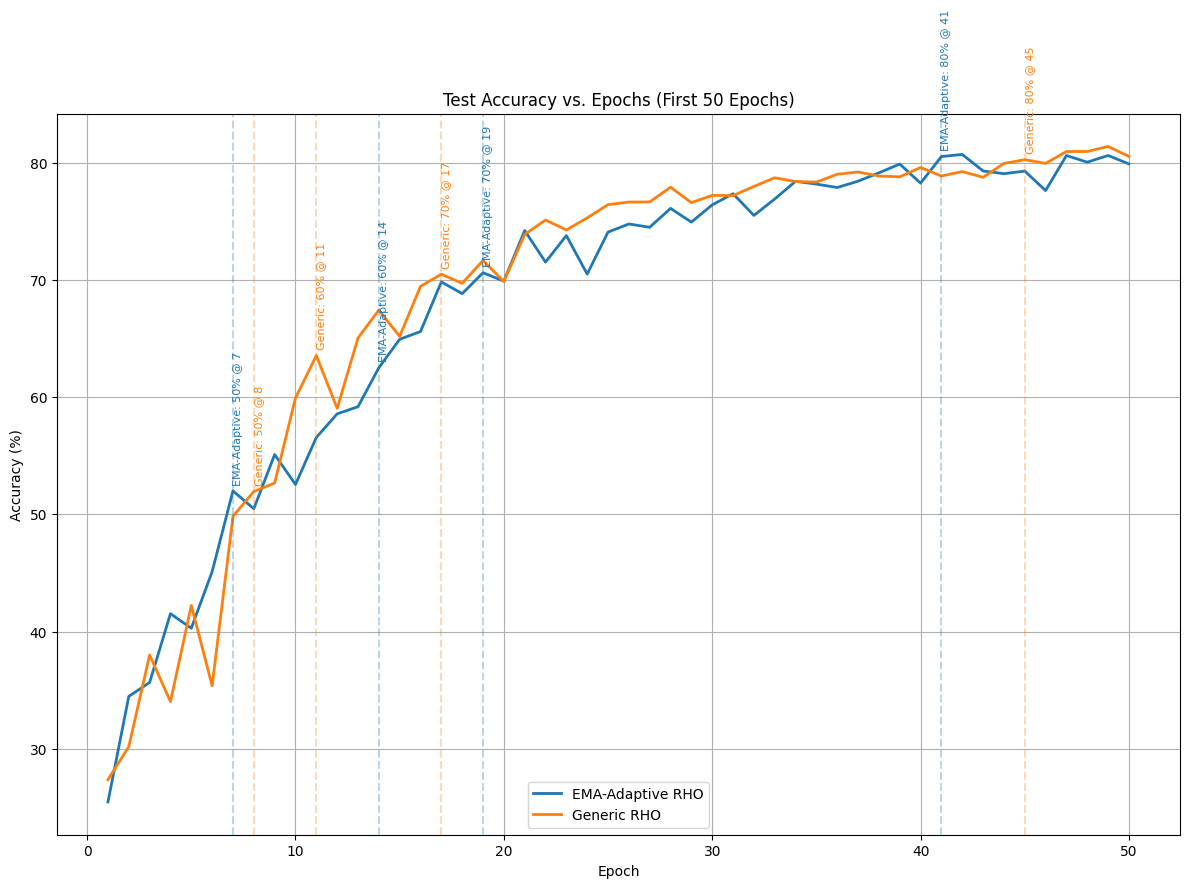

In [ ]:
import matplotlib.pyplot as plt

# Accuracy per epoch (first 50 epochs)
ema_adaptive_rho = [
    25.48, 34.48, 35.67, 41.53, 40.29, 45.12, 52.0, 50.48, 55.1, 52.55,
    56.56, 58.57, 59.18, 62.5, 64.93, 65.59, 69.82, 68.82, 70.6, 69.89,
    74.2, 71.51, 73.77, 70.49, 74.07, 74.76, 74.48, 76.09, 74.92, 76.39,
    77.34, 75.49, 76.89, 78.4, 78.16, 77.87, 78.41, 79.12, 79.87, 78.24,
    80.51, 80.69, 79.28, 79.05, 79.27, 77.61, 80.6, 80.03, 80.6, 79.88
]

generic_rho = [
    27.38, 30.19, 38.01, 34.03, 42.23, 35.39, 49.84, 51.95, 52.67, 59.92,
    63.54, 59.04, 65.04, 67.42, 65.18, 69.44, 70.48, 69.7, 71.65, 69.85,
    73.87, 75.1, 74.25, 75.28, 76.41, 76.63, 76.64, 77.9, 76.58, 77.2,
    77.18, 77.96, 78.7, 78.38, 78.33, 79.0, 79.19, 78.85, 78.78, 79.58,
    78.85, 79.23, 78.74, 79.92, 80.24, 79.93, 80.94, 80.94, 81.37, 80.52
]

epochs = list(range(1, 51))
thresholds = [50, 60, 70, 80]

def mark_thresholds(ax, data, label, color):
    for thresh in thresholds:
        for i, val in enumerate(data):
            if val >= thresh:
                ax.axvline(i + 1, linestyle='--', alpha=0.3, color=color)
                ax.text(i + 1, val + 0.5, f'{label}: {thresh}% @ {i+1}', rotation=90,
                        verticalalignment='bottom', fontsize=8, color=color)
                break

plt.figure(figsize=(12, 9))
plt.plot(epochs, ema_adaptive_rho, label='EMA-Adaptive RHO', linewidth=2, color='tab:blue')
plt.plot(epochs, generic_rho, label='Generic RHO', linewidth=2, color='tab:orange')

ax = plt.gca()
mark_thresholds(ax, ema_adaptive_rho, "EMA-Adaptive", "tab:blue")
mark_thresholds(ax, generic_rho, "Generic", "tab:orange")

plt.title("Test Accuracy vs. Epochs (First 50 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


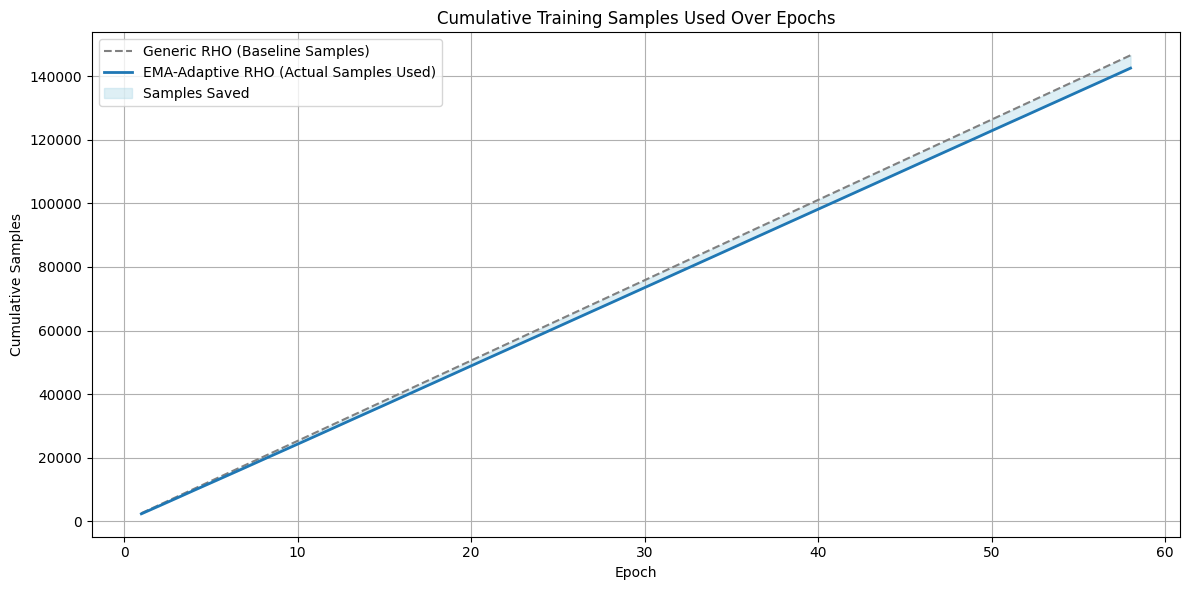

In [ ]:
import matplotlib.pyplot as plt

# Epochs 1 to 58
epochs = list(range(1, 59))

# Baseline samples: 2528 per epoch (fixed batch size of 320, top-32 kept, 10% = 2528 per epoch)
baseline_samples = [2528 * i for i in epochs]

# Actual samples used by EMA-Adaptive RHO (from training log)
actual_samples = [
    2340, 4749, 7186, 9636, 12060, 14486, 16922, 19379, 21815, 24259,
    26707, 29170, 31642, 34092, 36539, 39004, 41475, 43940, 46407, 48877,
    51351, 53805, 56264, 58721, 61187, 63657, 66121, 68573, 71045, 73514,
    75975, 78446, 80911, 83376, 85847, 88323, 90789, 93259, 95720, 98188,
    100647, 103115, 105580, 108052, 110525, 112996, 115461, 117927, 120387,
    122868, 125334, 127780, 130255, 132712, 135182, 137641, 140104, 142579
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, baseline_samples, label="Generic RHO (Baseline Samples)", linestyle='--', color='gray')
plt.plot(epochs, actual_samples, label="EMA-Adaptive RHO (Actual Samples Used)", linewidth=2, color='tab:blue')
plt.fill_between(epochs, actual_samples, baseline_samples, color='lightblue', alpha=0.4, label="Samples Saved")

plt.title("Cumulative Training Samples Used Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cumulative Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


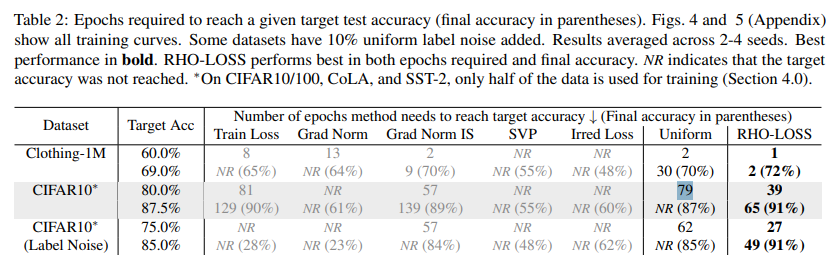